### Importing Libraries

In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.utils import class_weight
from tensorflow.data import Dataset
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Lambda
from tensorflow.keras.metrics import Precision, Recall, F1Score
from tensorflow.keras.losses import BinaryFocalCrossentropy
from keras.saving import load_model

In [11]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.precision = tf.keras.metrics.Precision(thresholds=threshold)
        self.recall = tf.keras.metrics.Recall(thresholds=threshold)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_bin = tf.cast(y_pred > self.threshold, tf.float32)
        self.precision.update_state(y_true, y_pred_bin, sample_weight)
        self.recall.update_state(y_true, y_pred_bin, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


###Data Loading

In [12]:
def process_image(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_png(image, channels=3)
    return image, label

def process_image_test(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_png(image, channels=3)
    return image

In [4]:
directory = '' #Insert the full path of your data here
train_csv = pd.read_csv(os.path.join(directory,'train.csv'))
train_csv["full_path"] = train_csv["path"].apply(lambda x: os.path.join(directory, x))
image_paths = train_csv["full_path"].tolist()
labels = train_csv["label"].tolist()
train_ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))
train_ds = train_ds.map(process_image)
train_ds = train_ds.batch(32).shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)

val_csv = pd.read_csv(os.path.join(directory,'val.csv'))
val_csv["full_path"] = val_csv["path"].apply(lambda x: os.path.join(directory, x))
image_paths = val_csv["full_path"].tolist()
labels = val_csv["label"].tolist()
val_ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))
val_ds = val_ds.map(process_image)
val_ds = val_ds.batch(32).shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)


test_csv = pd.read_csv(os.path.join(directory,'test.csv'))
test_csv["full_path"] = test_csv["path"].apply(lambda x: os.path.join(directory, x))
image_paths = test_csv["full_path"].tolist()
test_ds = tf.data.Dataset.from_tensor_slices((image_paths))
test_ds = test_ds.map(process_image_test)
test_ds = test_ds.batch(32).shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)

solutions = pd.read_csv(os.path.join(directory,'solution_PRIVATE.csv'))['label'].tolist()

### Model Loading (Only run this if your model is saved in the directory you mentioned aboe with name passport.keras)

In [14]:
model = load_model(os.path.join(directory,'passport.keras'), custom_objects={'preprocess_input': preprocess_input,'F1Score':F1Score()})

###Model Construction (Only run this if you didn't load your model)

In [28]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False

model_new = models.Sequential([
    Lambda(preprocess_input, name="resnet50_preprocessing"),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid'),
])

inputs = layers.Input(shape=(512, 512, 3))
x = layers.Resizing(224, 224)(inputs)
x = layers.RandomFlip("horizontal")(x, training=True)
outputs = model_new(x)

model = models.Model(inputs, outputs)


In [20]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 1)              │    24,669,697 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,669,697 (94.11 MB)

 Trainable params: 1,081,985 (4.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
model_new.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50_preprocessing (Lambda) │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,669,697 (94.11 MB)

 Trainable params: 1,081,985 (4.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

###Model Compilation (Only run this if you didn't load your model)

In [29]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=[Precision(),Recall(),F1Score()]
)

###Model Training (Only run this if you didn't load your model)

In [22]:
labels = train_csv['label']
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(weights))
class_weights[1] = np.float64(3)
class_weights

{0: np.float64(0.5234210526315789), 1: np.float64(3.0)}

In [30]:
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    verbose=1,
    shuffle = True,
    class_weight = class_weights
)


Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 79s 300ms/step - f1_score: 0.0171 - loss: 0.3853 - precision_4: 0.0190 - recall_4: 0.0158 - val_f1_score: 0.0000e+00 - val_loss: 0.2903 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 152ms/step - f1_score: 0.1225 - loss: 0.3174 - precision_4: 0.2022 - recall_4: 0.0895 - val_f1_score: 0.0000e+00 - val_loss: 0.2227 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 79s 144ms/step - f1_score: 0.1311 - loss: 0.3086 - precision_4: 0.1909 - recall_4: 0.1060 - val_f1_score: 0.1364 - val_loss: 0.1972 - val_precision_4: 0.5000 - val_recall_4: 0.0789
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 83s 155ms/step - f1_score: 0.1391 - loss: 0.2714 - precision_4: 0.1389 - recall_4: 0.1401 - val_f1_score: 0.2128 - val_loss: 0.2651 - val_precision_4: 0.5556 - val_recall_4: 0.1316
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 81s 147ms/step - f1_score: 0.1963 - loss: 0.2764 - p

/tmp/ipython-input-32-65058453.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


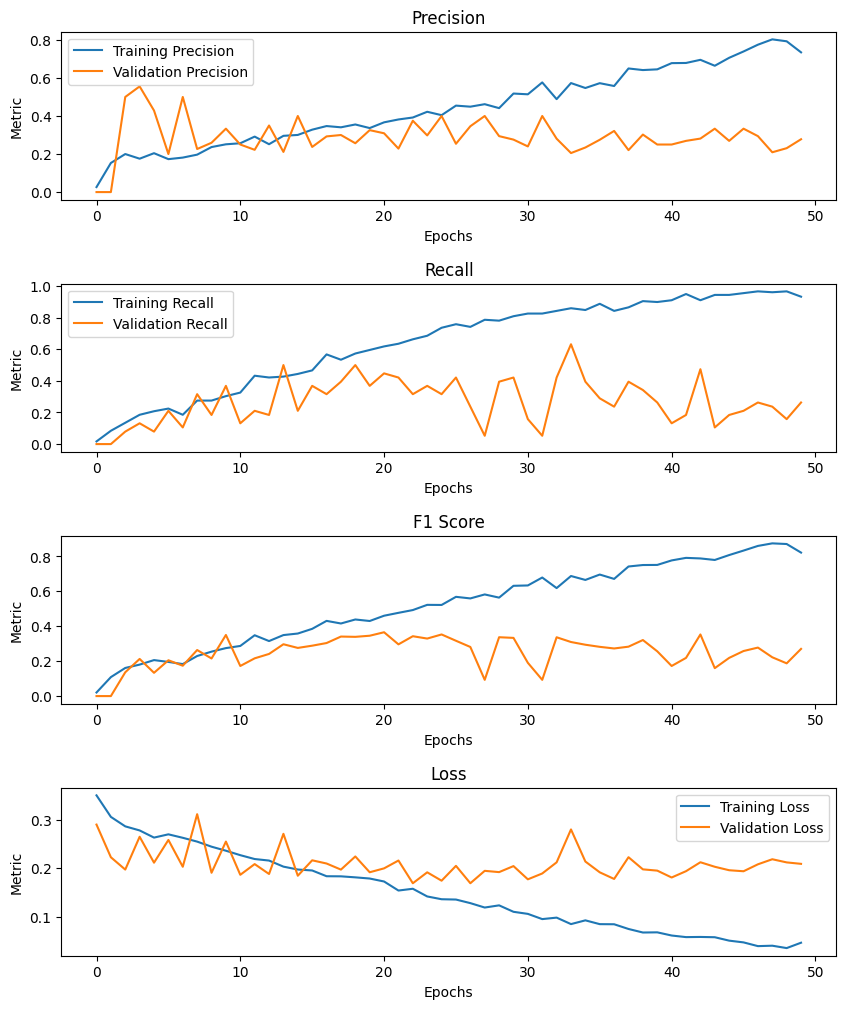

In [32]:
plt.figure(figsize=(10, 12))
plt.subplot(4,1,1)
plt.title("Precision")
plt.plot(history.history['precision_4'],label='Training Precision')
plt.plot(history.history['val_precision_4'],label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()
plt.subplot(4,1,2)
plt.title("Recall")
plt.plot(history.history['recall_4'],label='Training Recall')
plt.plot(history.history['val_recall_4'],label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()
plt.subplot(4,1,3)
plt.title("F1 Score")
plt.plot(history.history['f1_score'],label='Training F1 Score')
plt.plot(history.history['val_f1_score'],label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.subplot(4,1,4)
plt.legend()
plt.title("Loss")
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()
plt.subplots_adjust(hspace=0.5)
plt.show()

In [16]:
model.save(os.path.join(directory,'passport.keras'))

### Testing the Model

In [27]:
test_predictions = model.predict(test_ds)

27/27 ━━━━━━━━━━━━━━━━━━━━ 307s 6s/step


In [28]:
test_predictions_copy = [1 if prediction[0] >= 0.5 else 0 for prediction in test_predictions]

In [29]:
precision = precision_score(solutions, test_predictions_copy)
recall = recall_score(solutions, test_predictions_copy)
accuracy = accuracy_score(solutions, test_predictions_copy)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")

Precision: 0.15151515151515152
Recall: 0.1282051282051282
Accuracy: 0.9273153575615475


In [35]:
test_csv["label"] = test_predictions_copy
test_csv.to_csv("predictions.csv", index=False)